In [22]:
import pickle
import os

In [23]:
symbol='BTCUSDT'


"""
Los datos se obtienen con el script depth_get.py
"""
LOG_DIR = os.path.join('..','log')
DATA_FILE = os.path.join(LOG_DIR, f"order_book_{symbol}.pkl")
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, "rb") as archivo:
        depth = pickle.load(archivo)

bids = depth['bids']
asks = depth['asks']

## Analizando Depth por espacios de porcentaje

Base price: 83214.77


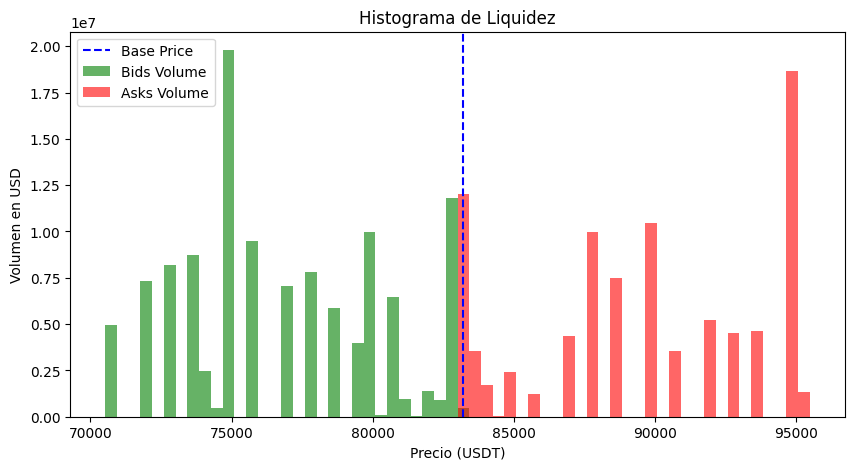

In [24]:
import numpy as np
import matplotlib.pyplot as plt

qd_price = 2
qd_quote = 2

# 1️⃣ Calcular el precio base
base_price = round((asks[0][0] + bids[0][0]) / 2 , qd_price)
print(f'Base price: {base_price:.2f}')

# 2️⃣ Definir los rangos del histograma
bin_size_pct = 0.5 / 100  # 0.5% del precio base
num_bins = 30  # Puedes ajustar la cantidad de bins
price_bins = [round(base_price * (1 + bin_size_pct * i) , qd_price) for i in range(-num_bins, num_bins + 1)]

# 3️⃣ Agrupar los datos en los bins
def calculate_volume_by_bin(order_book, bins):
    volume_per_bin = np.zeros(len(bins) - 1)
    
    for price, quantity in order_book:
        usd_volume = price * quantity
        bin_index = np.digitize(price, bins) - 1  # Encuentra el índice del bin
        
        if 0 <= bin_index < len(volume_per_bin):  # Evitar errores de índice
            volume_per_bin[bin_index] += usd_volume

    return volume_per_bin

bids_volume = calculate_volume_by_bin(bids, price_bins)
bids_volume = [round(v, qd_quote) for v in bids_volume]
asks_volume = calculate_volume_by_bin(asks, price_bins)

# 4️⃣ Graficar el histograma de liquidez
plt.figure(figsize=(10, 5))
plt.bar(price_bins[:-1], bids_volume, width=(bin_size_pct * base_price), color='green', alpha=0.6, label='Bids Volume')
plt.bar(price_bins[:-1], asks_volume, width=(bin_size_pct * base_price), color='red', alpha=0.6, label='Asks Volume')

plt.axvline(base_price, color='blue', linestyle='dashed', label='Base Price')
plt.xlabel('Precio (USDT)')
plt.ylabel('Volumen en USD')
plt.title('Histograma de Liquidez')
plt.legend()
plt.show()


## Desarrollo para almacenar los datos en un historico

In [25]:
import pickle
import pandas as pd
from datetime import datetime
import os
import numpy as np

class OrderBookAnalyzer:
    def __init__(self, data_file=''):
        self.data_file = data_file
        if len(self.data_file)>0:
            self.df = self.load_or_create_dataframe()

    def load_or_create_dataframe(self):
        """Carga el DataFrame existente o crea uno nuevo"""
        if os.path.exists(self.data_file):
            with open(self.data_file, 'rb') as f:
                return pickle.load(f)
        return pd.DataFrame(columns=[
            'timestamp',
            'base_price',
            'bid_supports',
            'ask_resistances',
            'total_bid_volume',
            'total_ask_volume',
            'bid_volume_distribution',
            'ask_volume_distribution',
            'market_imbalance'
        ])

    def find_significant_levels(self, levels, is_bid=True, volume_threshold_pct=7.0, price_range_pct=1.0):
        """
        Identifica niveles significativos con métricas relativas
        
        Args:
            levels: Lista de [precio, cantidad]
            is_bid: True para bids, False para asks
            volume_threshold_pct: Umbral porcentual mínimo para considerar nivel
            price_range_pct: Rango alrededor del precio para calcular media
            
        Returns:
            Dict con niveles significativos y métricas
        """
        df = pd.DataFrame(levels, columns=['price', 'amount'])
        df['volume'] = df['price'] * df['amount']
        total_volume = df['volume'].sum()
        
        # Convertir a porcentaje del volumen total
        df['volume_pct'] = (df['volume'] / total_volume) * 100
        
        # Calcular media del volumen en el rango de precios
        price_reference = df['price'].iloc[0]
        price_range = price_reference * (price_range_pct / 100)
        range_mask = (df['price'] >= price_reference - price_range) & \
                     (df['price'] <= price_reference + price_range)
        mean_volume_in_range = df[range_mask]['volume_pct'].mean()
        
        # Umbral dinámico (máximo entre 1.5x la media o 1%)
        dynamic_threshold = max(1.5 * mean_volume_in_range, volume_threshold_pct)
        
        # Filtrar niveles significativos
        significant_levels = df[df['volume_pct'] > dynamic_threshold].copy()
        significant_levels.sort_values('price', ascending=not is_bid, inplace=True)
        
        # Calcular score de fortaleza relativa
        significant_levels['strength_score'] = significant_levels['volume_pct'] / mean_volume_in_range
        
        # Agrupar niveles cercanos (clusters)
        price_group_size = price_reference * 0.005  # Agrupa en bins de 0.5%
        significant_levels['price_group'] = (significant_levels['price'] / price_group_size).round()
        
        clusters = significant_levels.groupby('price_group').agg({
            'price': 'first',
            'volume': 'sum',
            'volume_pct': 'sum',
            'strength_score': 'mean'
        }).reset_index(drop=True)
        
        return {
            'levels': clusters.to_dict('records'),
            'total_volume': total_volume,
            'mean_volume_pct_in_range': mean_volume_in_range,
            'price_reference': price_reference,
            'dynamic_threshold': dynamic_threshold
        }

    def calculate_volume_distribution(self, levels, base_price):
        """Calcula distribución del volumen por rangos porcentuales (versión corregida)"""
        df = pd.DataFrame(levels, columns=['price', 'amount'])
        df['volume'] = df['price'] * df['amount']
        
        # Definir los bins correctamente
        bins_pct = [-5, -2, -1, -0.5, 0, 0.5, 1, 2, 5]
        bins = [base_price * (1 + p/100) for p in bins_pct]
        
        # Añadir -infinito e infinito para capturar valores fuera del rango
        bins = [-np.inf] + bins + [np.inf]
        
        # Definir etiquetas que correspondan a los bins
        labels = [
            '<-5%', 
            '-5% to -2%', 
            '-2% to -1%', 
            '-1% to -0.5%', 
            '-0.5% to 0%',
            '0% to 0.5%', 
            '0.5% to 1%', 
            '1% to 2%', 
            '2% to 5%', 
            '>5%'
        ]
        
        # Verificar que tenemos una etiqueta menos que los bins
        assert len(bins) == len(labels) + 1, "Número de bins y etiquetas no coincide"
        
        df['price_pct_from_base'] = (df['price'] - base_price) / base_price * 100
        df['price_bin'] = pd.cut(
            df['price'], 
            bins=bins, 
            labels=labels,
            include_lowest=True
        )
        
        distribution = df.groupby('price_bin')['volume'].sum().to_dict()
        total = sum(distribution.values())
        distribution_pct = {k: (v/total*100 if total > 0 else 0) for k, v in distribution.items()}
        
        return {
            'absolute': distribution,
            'percentage': distribution_pct,
            'total_volume': total,
            'bins_used': bins,
            'labels_used': labels
        }

    def calculate_market_imbalance(self, bid_data, ask_data):
        """Calcula el desequilibrio entre compra y venta"""
        total_bid = bid_data['total_volume']
        total_ask = ask_data['total_volume']
        total = total_bid + total_ask
        
        if total > 0:
            imbalance = (total_bid - total_ask) / total * 100  # -100 a +100
            bid_dominance = total_bid / total * 100
        else:
            imbalance = 0
            bid_dominance = 50
            
        return {
            'imbalance_pct': imbalance,
            'bid_dominance_pct': bid_dominance,
            'ratio': total_bid / total_ask if total_ask > 0 else np.inf
        }

    def analyze_order_book(self, bids, asks):
        """Analiza el libro de órdenes completo"""
        # 1. Precio base y referencia
        base_price = (asks[0][0] + bids[0][0]) / 2
        
        # 2. Niveles significativos
        bid_supports = self.find_significant_levels(bids, is_bid=True)
        ask_resistances = self.find_significant_levels(asks, is_bid=False)
        
        # 3. Distribución del volumen
        bid_distribution = self.calculate_volume_distribution(bids, base_price)
        ask_distribution = self.calculate_volume_distribution(asks, base_price)
        
        # 4. Desequilibrio del mercado
        market_imbalance = self.calculate_market_imbalance(bid_supports, ask_resistances)
        
        # 5. Crear nuevo registro
        new_record = {
            'timestamp': datetime.now(),
            'base_price': base_price,
            'bid_supports': bid_supports,
            'ask_resistances': ask_resistances,
            'total_bid_volume': bid_supports['total_volume'],
            'total_ask_volume': ask_resistances['total_volume'],
            'bid_volume_distribution': bid_distribution,
            'ask_volume_distribution': ask_distribution,
            'market_imbalance': market_imbalance
        }
        
        # 6. Actualizar DataFrame
        self.df = pd.concat([self.df, pd.DataFrame([new_record])], ignore_index=True)
        
        ## 7. Guardar datos
        if len(self.data_file)>0:   
            with open(self.data_file, 'wb') as f:
                pickle.dump(self.df, f)
            
        return new_record

    def get_summary_stats(self, last_n=24):
        """Devuelve estadísticas resumidas de los últimos N registros"""
        if len(self.df) < 1:
            return None
            
        last_records = self.df.tail(last_n)
        
        return {
            'mean_imbalance': last_records['market_imbalance'].apply(lambda x: x['imbalance_pct']).mean(),
            'mean_bid_dominance': last_records['market_imbalance'].apply(lambda x: x['bid_dominance_pct']).mean(),
            'support_levels': self.aggregate_levels(last_records, 'bid_supports'),
            'resistance_levels': self.aggregate_levels(last_records, 'ask_resistances'),
            'price_change_pct': (last_records['base_price'].iloc[-1] / last_records['base_price'].iloc[0] - 1) * 100
        }
    
    def aggregate_levels(self, df, level_type):
        """Agrega niveles a lo largo del tiempo"""
        all_levels = []
        for _, row in df.iterrows():
            for level in row[level_type]['levels']:
                all_levels.append({
                    'price': level['price'],
                    'volume_pct': level['volume_pct'],
                    'strength_score': level['strength_score']
                })
        
        if not all_levels:
            return []
            
        levels_df = pd.DataFrame(all_levels)
        levels_df['price_bin'] = pd.cut(levels_df['price'], bins=20)
        
        aggregated = levels_df.groupby('price_bin').agg({
            'price': 'mean',
            'volume_pct': ['mean', 'count'],
            'strength_score': 'mean'
        }).reset_index()
        
        aggregated.columns = ['price_bin', 'mean_price', 'mean_volume_pct', 'frequency', 'mean_strength']
        aggregated = aggregated[aggregated['frequency'] > 1]  # Filtra niveles poco frecuentes
        
        return aggregated.sort_values('mean_volume_pct', ascending=False).to_dict('records')



    
DATA_FILE = os.path.join(LOG_DIR, f"depth_{symbol}_historic.pkl")
analyzer = OrderBookAnalyzer(DATA_FILE)
analysis_result = analyzer.analyze_order_book(bids, asks)

print("Análisis completado. Resumen:")
print(f"Precio base: {analysis_result['base_price']}")
print(f"Desbalance del mercado: {analysis_result['market_imbalance']['imbalance_pct']:.2f}%")
print(f"Soportes significativos encontrados: {len(analysis_result['bid_supports']['levels'])}")
for s in analysis_result['bid_supports']['levels']:
    print(f"{s['price']}", f"{s['volume_pct']:.2f} %")
print(f"Resistencias significativas encontradas: {len(analysis_result['ask_resistances']['levels'])}")
for s in analysis_result['ask_resistances']['levels']:
    print(f"{s['price']}", f"{s['volume_pct']:.2f} %")

#daily_summary = analyzer.get_summary_stats(24)
#weekly_summary = analyzer.get_summary_stats(168)
# Obtener resumen de las últimas 24 horas
#summary = analyzer.get_summary_stats(24)
#if summary:
#    print("\nResumen últimas 24 horas:")
#    print(f"Desbalance promedio: {summary['mean_imbalance']:.2f}%")
#    print(f"Dominancia de compra promedio: {summary['mean_bid_dominance']:.2f}%")


Análisis completado. Resumen:
Precio base: 83214.775
Desbalance del mercado: 30.22%
Soportes significativos encontrados: 1
75000.0 10.61 %
Resistencias significativas encontradas: 4
88000.0 10.25 %
89000.0 7.75 %
90000.0 10.79 %
95000.0 19.25 %
